# Homework 1: How much data do you need? Using CIFAR-100
Advanced AI Methods \\
Dr. Kerby

## Question 1: Create a CNN to classify CIFAR-100
Use the [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) dataset. This [link](https://www.cs.toronto.edu/~kriz/cifar.html) also has some useful information.

You can utilize `keras.datasets.cifar100.load_data()` to import the dataset as `numpy ndarrays` or `tfds.load('cifar100')` to import the dataset as `tf.data.Dataset`.

You must utilize transfer learning. You are welcome to choose any of the expert CNN models available in [Keras Applications](https://keras.io/api/applications/). I think EfficientNetV2 is probably the best, but it would be fun to see if the results hold for other expert CNNs, so feel free to try a different one and we'll compare.

Your image classifier should output both labels (the coarse and fine labels). First create a classifier for all 100 classes and utilizing all available training data (500 images per class). Report your accuracy for both training and testing, for both the coarse and fine labels. This accuracy will serve as a baseline accuracy for later on. Plot several misclassified images. Plot a confusion matrix for the coarse labels.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode = 'fine')
X_train_tr, X_train_v, y_train_tr, y_train_v= train_test_split(X_train, y_train, test_size=0.10)
(X_train_c, y_train_c), (X_test_c, y_test_c) = cifar100.load_data(label_mode = 'coarse')
X_train_tr_c, X_train_v_c, y_train_tr_c, y_train_v_c= train_test_split(X_train_c, y_train_c, test_size=0.10)

169017344/169001437 [==============================] - 11s 0us/step


In [ ]:
X_train_tr.shape

(45000, 32, 32, 3)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train_c = tf.data.Dataset.from_tensor_slices( (X_train_tr_c, y_train_tr_c) )
ds_valid_c = tf.data.Dataset.from_tensor_slices((X_train_v_c, y_train_v_c))
ds_test_c = tf.data.Dataset.from_tensor_slices((X_test_c, y_test_c))

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


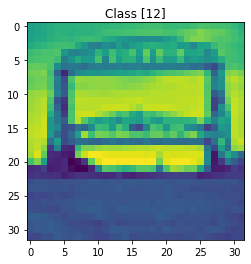

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


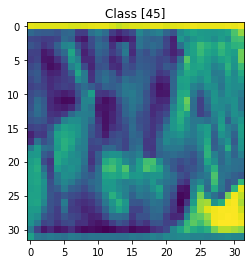

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


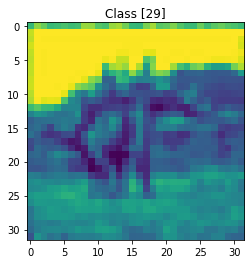

In [ ]:
import matplotlib.pyplot as plt
for element in ds_train.take(3):
  image, label = element[0], element[1] 
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


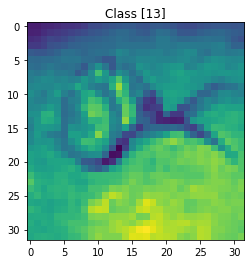

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


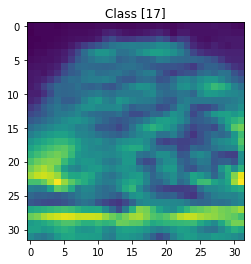

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


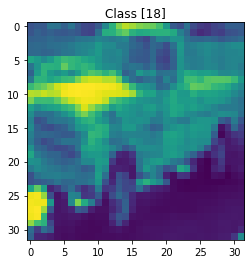

In [ ]:
import matplotlib.pyplot as plt
for element in ds_train_c.take(3):
  image, label = element[0], element[1] # now its coarse
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

ds_train_c=ds_train_c.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid_c=ds_valid_c.map(preprocess).batch(32).prefetch(1)
ds_test_c=ds_test_c.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 - 67s - loss: 1.8280 - accuracy: 0.5415 - val_loss: 1.0427 - val_accuracy: 0.7028 - 67s/epoch - 47ms/step
Epoch 2/50
1407/1407 - 58s - loss: 1.2385 - accuracy: 0.6625 - val_loss: 0.9499 - val_accuracy: 0.7256 - 58s/epoch - 41ms/step
Epoch 3/50
1407/1407 - 68s - loss: 1.0810 - accuracy: 0.7039 - val_loss: 0.9158 - val_accuracy: 0.7362 - 68s/epoch - 48ms/step
Epoch 4/50
1407/1407 - 68s - loss: 0.9766 - accuracy: 0.7315 - val_loss: 0.9005 - val_accuracy: 0.7392 - 68s/epoch - 48ms/step
Epoch 5/50
1407/1407 - 65s - loss: 0.8967 - accuracy: 0.7538 - val_loss: 0.8947 - val_accuracy: 0.7396 - 65s/epoch - 46ms/step
Epoch 6/50
1407/1407 - 67s - loss: 0.8315 - accuracy: 0.7718 - val_loss: 0.8943 - val_accuracy: 0.7406 - 67s/epoch - 48ms/step
Epoch 7/50
1407/1407 - 66s - loss: 0.7771 - accuracy: 0.7893 - val_loss: 0.8968 - val_accuracy: 0.7404 - 66s/epoch - 47ms/step
Epoch 8/50
1407/1407 - 65s - loss: 0.7310 - accuracy: 0.8033 - val_loss: 0.9010 - val_accuracy: 0.7428 - 65s/ep

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 - 209s - loss: 0.9661 - accuracy: 0.7261 - val_loss: 0.7032 - val_accuracy: 0.7926 - 209s/epoch - 149ms/step
Epoch 2/50
1407/1407 - 182s - loss: 0.2743 - accuracy: 0.9225 - val_loss: 0.7019 - val_accuracy: 0.8072 - 182s/epoch - 129ms/step
Epoch 3/50
1407/1407 - 181s - loss: 0.0660 - accuracy: 0.9886 - val_loss: 0.7361 - val_accuracy: 0.8060 - 181s/epoch - 129ms/step
Epoch 4/50
1407/1407 - 181s - loss: 0.0153 - accuracy: 0.9993 - val_loss: 0.7774 - val_accuracy: 0.8134 - 181s/epoch - 129ms/step
Epoch 5/50
1407/1407 - 181s - loss: 0.0224 - accuracy: 0.9948 - val_loss: 0.9188 - val_accuracy: 0.7910 - 181s/epoch - 128ms/step
Epoch 6/50
1407/1407 - 181s - loss: 0.0571 - accuracy: 0.9853 - val_loss: 0.8002 - val_accuracy: 0.8126 - 181s/epoch - 129ms/step
Epoch 7/50
1407/1407 - 181s - loss: 0.0124 - accuracy: 0.9984 - val_loss: 0.8111 - val_accuracy: 0.8234 - 181s/epoch - 129ms/step
CPU times: user 33min 20s, sys: 3min 19s, total: 36min 39s
Wall time: 22min 57s


In [ ]:
history = model.evaluate(ds_test)

313/313 [==============================] - 10s 32ms/step - loss: 0.8446 - accuracy: 0.8144


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[96  0  0 ...  0  0  0]
 [ 0 93  0 ...  0  0  0]
 [ 0  1 72 ...  0  1  0]
 ...
 [ 0  0  0 ... 80  0  0]
 [ 0  0  1 ...  0 64  0]
 [ 0  0  0 ...  0  0 86]]
              precision    recall  f1-score   support

           0      0.906     0.960     0.932       100
           1      0.861     0.930     0.894       100
           2      0.720     0.720     0.720       100
           3      0.699     0.720     0.709       100
           4      0.698     0.740     0.718       100
           5      0.802     0.810     0.806       100
           6      0.795     0.890     0.840       100
           7      0.882     0.820     0.850       100
           8      0.892     0.910     0.901       100
           9      0.848     0.890     0.868       100
          10      0.702     0.590     0.641       100
          11      0.533     0.480     0.505       100
          12      0.897     0.870     0.883       100
          13      0.918     0.780     0.843       100
          14      0.859     0.790

In [ ]:
# Freeze transferred layers and train for coarse label
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history_2 = model.fit(ds_train_c, 
                    epochs=50, validation_data=ds_valid_c, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 - 64s - loss: 2.4889 - accuracy: 0.6404 - val_loss: 0.4366 - val_accuracy: 0.8822 - 64s/epoch - 46ms/step
Epoch 2/50
1407/1407 - 68s - loss: 0.4238 - accuracy: 0.8853 - val_loss: 0.3304 - val_accuracy: 0.9046 - 68s/epoch - 48ms/step
Epoch 3/50
1407/1407 - 67s - loss: 0.3200 - accuracy: 0.9086 - val_loss: 0.2911 - val_accuracy: 0.9126 - 67s/epoch - 47ms/step
Epoch 4/50
1407/1407 - 67s - loss: 0.2617 - accuracy: 0.9222 - val_loss: 0.2701 - val_accuracy: 0.9194 - 67s/epoch - 48ms/step
Epoch 5/50
1407/1407 - 65s - loss: 0.2222 - accuracy: 0.9327 - val_loss: 0.2579 - val_accuracy: 0.9220 - 65s/epoch - 46ms/step
Epoch 6/50
1407/1407 - 67s - loss: 0.1940 - accuracy: 0.9412 - val_loss: 0.2514 - val_accuracy: 0.9246 - 67s/epoch - 47ms/step
Epoch 7/50
1407/1407 - 65s - loss: 0.1719 - accuracy: 0.9488 - val_loss: 0.2468 - val_accuracy: 0.9260 - 65s/epoch - 46ms/step
Epoch 8/50
1407/1407 - 66s - loss: 0.1541 - accuracy: 0.9541 - val_loss: 0.2448 - val_accuracy: 0.9278 - 66s/ep

In [ ]:
# Unfreeze layers and train for coarse label
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history_2 = model.fit(ds_train_c,
                    epochs=50,
                    validation_data=ds_valid_c, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
1407/1407 - 207s - loss: 0.3023 - accuracy: 0.9029 - val_loss: 0.2544 - val_accuracy: 0.9236 - 207s/epoch - 147ms/step
Epoch 2/50
1407/1407 - 181s - loss: 0.0365 - accuracy: 0.9899 - val_loss: 0.2476 - val_accuracy: 0.9304 - 181s/epoch - 129ms/step


KeyboardInterrupt: ignored

In [ ]:
history_2 = model.evaluate(ds_test_c)

313/313 [==============================] - 10s 32ms/step - loss: 0.4549 - accuracy: 0.8960


In [ ]:
y_pred_fine = model.predict(ds_test_c)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test_c], axis=0)
print(predicted_categories, true_categories)

tf.Tensor([ 9 11  0 ...  4  8  2], shape=(10000,), dtype=int64) tf.Tensor(
[[10]
 [10]
 [ 0]
 ...
 [ 4]
 [ 8]
 [ 2]], shape=(10000, 1), dtype=int64)


Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

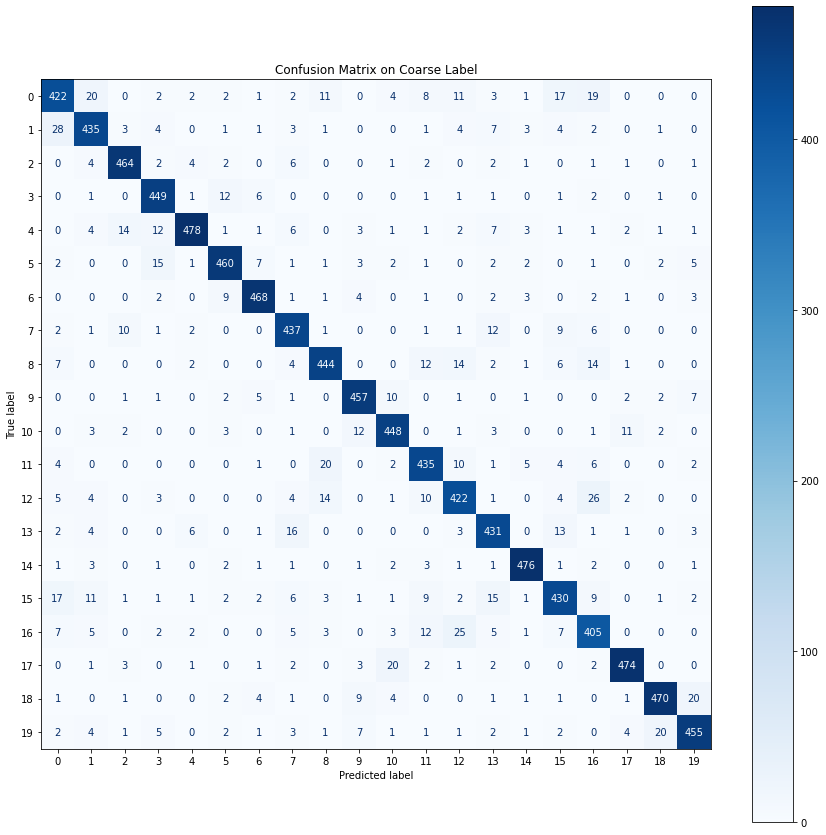

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

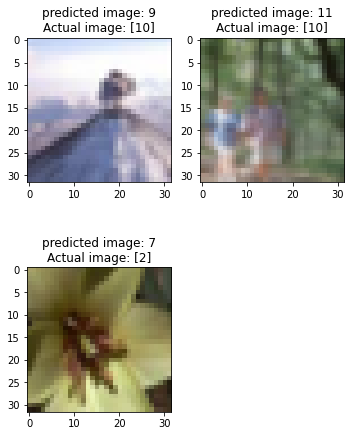

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,50))
for i in range(6):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(12,5,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[422  28   0   0   0   2   0   2   7   0   0   4   5   2   1  17   7   0
    1   2]
 [ 20 435   4   1   4   0   0   1   0   0   3   0   4   4   3  11   5   1
    0   4]
 [  0   3 464   0  14   0   0  10   0   1   2   0   0   0   0   1   0   3
    1   1]
 [  2   4   2 449  12  15   2   1   0   1   0   0   3   0   1   1   2   0
    0   5]
 [  2   0   4   1 478   1   0   2   2   0   0   0   0   6   0   1   2   1
    0   0]
 [  2   1   2  12   1 460   9   0   0   2   3   0   0   0   2   2   0   0
    2   2]
 [  1   1   0   6   1   7 468   0   0   5   0   1   0   1   1   2   0   1
    4   1]
 [  2   3   6   0   6   1   1 437   4   1   1   0   4  16   1   6   5   2
    1   3]
 [ 11   1   0   0   0   1   1   1 444   0   0  20  14   0   0   3   3   0
    0   1]
 [  0   0   0   0   3   3   4   0   0 457  12   0   0   0   1   1   0   3
    9   7]
 [  4   0   1   0   1   2   0   0   0  10 448   2   1   0   2   1   3  20
    4   1]
 [  8   1   2   1   1   1   1   1  12   0   0 435  10   0   3   9

## Question 2: Performance on 20-class subset of CIFAR-100
### Part 2A: Performance on "different" classes
Choose the 20 class subset such that there is one class from each of the 20 superclasses. Re-train a transfer learning model, similar to what you did in Part 1. 

How much data do you need to achieve similar accuracy as you achieved in Part 1? (ie how many images from each class is needed?)

What is your accuracy, for coarse and fine labels for both training and testing, if you utilize all available training data (ie 500 images per class)?

Plot several misclassified images. Plot confusion matrices for both coarse and fine labels.


In [ ]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
(_, y_coarse_train), (_, y_coarse_test) =cifar100.load_data(label_mode='coarse')

size = 100
subclass_ID = 3 
y_train_full_dup = y_train_full
y_test_dup=y_test

# Remove single-dimensional entries for labels
y_train_full_sq = np.squeeze(y_train_full)
y_test_sq = np.squeeze(y_test)
y_coarse_train_sq = np.squeeze(y_coarse_train)
y_coarse_test_sq = np.squeeze(y_coarse_test)

# Define empty matrices 
X_train_new=np.empty((0,32,32,3))
y_train_new=np.empty((0,1))
X_test_new=np.empty((0,32,32,3))
y_test_new=np.empty((0,1))
cls_matrix=np.empty((0,5))

# Preparing a class matrix which has all the superclass ordered
for i in np.arange(0,20,1): 
  cls_matrix=np.vstack((cls_matrix,np.unique(y_train_full[y_coarse_train_sq==i])))

# Sorting out data according to subclass for training, 500 per subclass
for i in np.arange(0,20,1):
  delta = np.squeeze(y_train_full==cls_matrix[i,subclass_ID],axis=1)
  y_train_full[delta]=i # Super class
  X_train_new=np.vstack((X_train_new, X_train_full[delta][0:size]))
  y_train_new=np.vstack((y_train_new, y_train_full[delta][0:size]))


# Sorting out data according to subclass for testing
for i in np.arange(0,20,1):
  delta = np.squeeze(y_test==cls_matrix[i,subclass_ID],axis=1)
  y_test[delta]=i # Super class
  X_test_new = np.vstack((X_test_new, X_test[delta]))
  y_test_new = np.vstack((y_test_new, y_test[delta]))

# Randomize data for training and testing
data_points_tr = np.shape(X_train_new)[0]
data_random_tr=np.random.permutation(data_points_tr)
X_train_new=X_train_new[data_random_tr].astype(int)
y_train_new=y_train_new[data_random_tr].astype(int)

data_points_test = np.shape(X_test_new)[0]
data_random_test=np.random.permutation(data_points_test)
X_test_new=X_test_new[data_random_test].astype(int)
y_test_new=y_test_new[data_random_test].astype(int)
##################################################################

test_size=np.floor(20*0.1*size).astype(int) # 10% validation size

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_new,
                                                                y_train_new,
                                                                test_size=test_size)

# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new))

169017344/169001437 [==============================] - 5s 0us/step


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


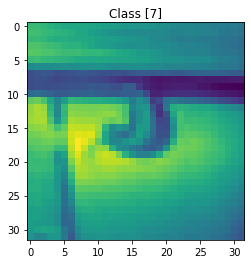

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


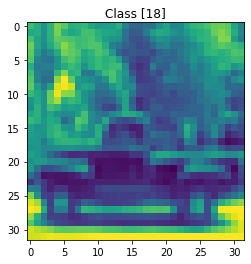

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


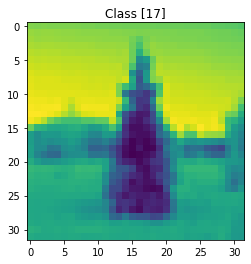

In [ ]:
import matplotlib.pyplot as plt
for element in ds_train.take(3):
  image, label = element[0], element[1]
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
57/57 - 19s - loss: 2.6032 - accuracy: 0.4411 - val_loss: 1.2392 - val_accuracy: 0.8100 - 19s/epoch - 330ms/step
Epoch 2/50
57/57 - 2s - loss: 1.1025 - accuracy: 0.7700 - val_loss: 0.7296 - val_accuracy: 0.8450 - 2s/epoch - 33ms/step
Epoch 3/50
57/57 - 2s - loss: 0.7881 - accuracy: 0.8167 - val_loss: 0.5934 - val_accuracy: 0.8600 - 2s/epoch - 33ms/step
Epoch 4/50
57/57 - 2s - loss: 0.6427 - accuracy: 0.8467 - val_loss: 0.5328 - val_accuracy: 0.8550 - 2s/epoch - 33ms/step
Epoch 5/50
57/57 - 2s - loss: 0.5507 - accuracy: 0.8700 - val_loss: 0.4994 - val_accuracy: 0.8550 - 2s/epoch - 34ms/step
Epoch 6/50
57/57 - 2s - loss: 0.4826 - accuracy: 0.8878 - val_loss: 0.4785 - val_accuracy: 0.8500 - 2s/epoch - 33ms/step
Epoch 7/50
57/57 - 2s - loss: 0.4291 - accuracy: 0.9017 - val_loss: 0.4645 - val_accuracy: 0.8550 - 2s/epoch - 33ms/step
Epoch 8/50
57/57 - 2s - loss: 0.3843 - accuracy: 0.9167 - val_loss: 0.4549 - val_accuracy: 0.8550 - 2s/epoch - 33ms/step
Epoch 9/50
57/57 - 2s - loss:

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
57/57 - 30s - loss: 1.7051 - accuracy: 0.7106 - val_loss: 0.5568 - val_accuracy: 0.8600 - 30s/epoch - 522ms/step
Epoch 2/50
57/57 - 7s - loss: 0.2899 - accuracy: 0.9394 - val_loss: 0.4893 - val_accuracy: 0.8500 - 7s/epoch - 123ms/step
Epoch 3/50
57/57 - 7s - loss: 0.0739 - accuracy: 0.9961 - val_loss: 0.4369 - val_accuracy: 0.8800 - 7s/epoch - 122ms/step
Epoch 4/50
57/57 - 7s - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.4080 - val_accuracy: 0.8900 - 7s/epoch - 122ms/step
Epoch 5/50
57/57 - 7s - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.4003 - val_accuracy: 0.8950 - 7s/epoch - 122ms/step
Epoch 6/50
57/57 - 7s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.3905 - val_accuracy: 0.8900 - 7s/epoch - 122ms/step
Epoch 7/50
57/57 - 7s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.3885 - val_accuracy: 0.9000 - 7s/epoch - 122ms/step
Epoch 8/50
57/57 - 7s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.3848 - val_accuracy: 0.9000 - 7s/epoch - 123ms/step
Epoch 9/50
57/57 - 7s 

In [ ]:
history = model.evaluate(ds_test)

63/63 [==============================] - 2s 32ms/step - loss: 0.3889 - accuracy: 0.8890


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
print(predicted_categories, true_categories)

tf.Tensor([18  4 15 ... 14  2 12], shape=(2000,), dtype=int64) tf.Tensor(
[[18]
 [ 4]
 [15]
 ...
 [14]
 [ 2]
 [12]], shape=(2000, 1), dtype=int64)


Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

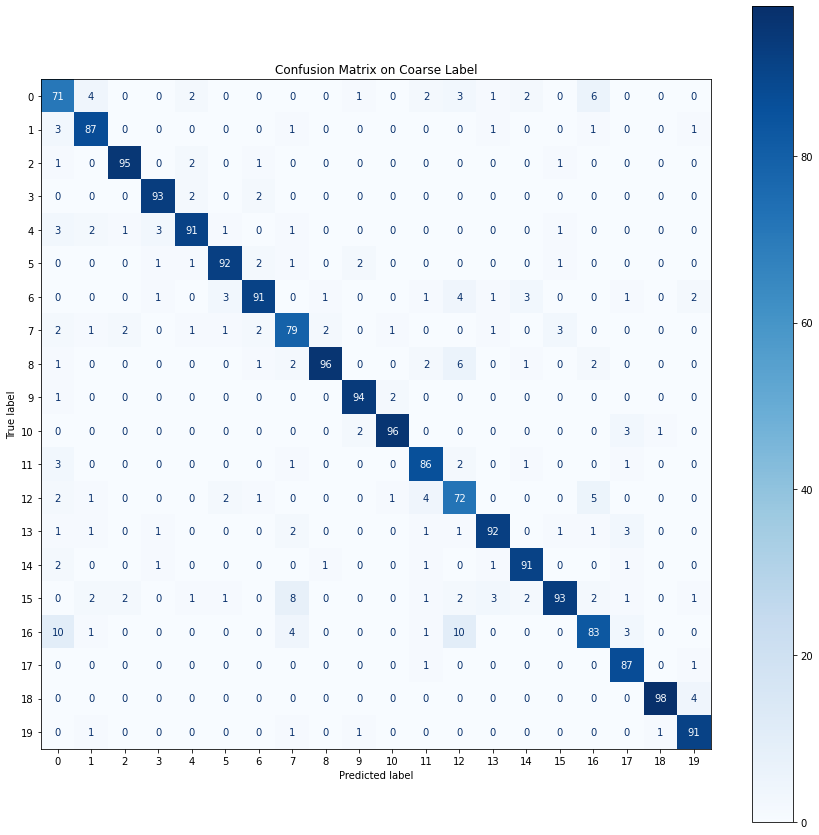

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

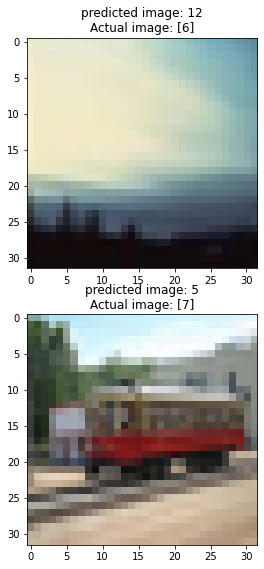

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (40,50))
for i in np.arange(0,20,1):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(10,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[71  3  1  0  3  0  0  2  1  1  0  3  2  1  2  0 10  0  0  0]
 [ 4 87  0  0  2  0  0  1  0  0  0  0  1  1  0  2  1  0  0  1]
 [ 0  0 95  0  1  0  0  2  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0 93  3  1  1  0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 2  0  2  2 91  1  0  1  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1 92  3  1  0  0  0  0  2  0  0  1  0  0  0  0]
 [ 0  0  1  2  0  2 91  2  1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  1  0 79  2  0  0  1  0  2  0  8  4  0  0  1]
 [ 0  0  0  0  0  0  1  2 96  0  0  0  0  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  0  0  0 94  2  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  1  0  2 96  0  1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  1  0  2  0  0 86  4  1  1  1  1  1  0  0]
 [ 3  0  0  0  0  0  4  0  6  0  0  2 72  1  0  2 10  0  0  0]
 [ 1  1  0  0  0  0  1  1  0  0  0  0  0 92  1  3  0  0  0  0]
 [ 2  0  0  0  0  0  3  0  1  0  0  1  0  0 91  2  0  0  0  0]
 [ 0  0  1  0  1  1  0  3  0  0  0  0  0  1  0 93  0  0

### Part 2B: Performance on "similar" classes
Choose your 20 classes such that they come from a minimum number of superclasses. Repeat your analysis from Part 2A:
1. Re-train a transfer learning model
2. Find how much data is needed to achieve similar accuracy as Part 1.
3. Find the maximum accuracy, utilizing all available training data.

Plot several misclassified images and confusion matrices.

Are your results different than they were for Part 2A?

In [ ]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
(_, y_coarse_train), (_, y_coarse_test) =cifar100.load_data(label_mode='coarse')

size = 100
 
y_train_full_dup = y_train_full
y_test_dup=y_test

# Remove single-dimensional entries for labels
y_train_full_sq = np.squeeze(y_train_full)
y_test_sq = np.squeeze(y_test)
y_coarse_train_sq = np.squeeze(y_coarse_train)
y_coarse_test_sq = np.squeeze(y_coarse_test)

# Define empty matrices 
X_train_new=np.empty((0,32,32,3))
y_train_new=np.empty((0,1))
X_test_new=np.empty((0,32,32,3))
y_test_new=np.empty((0,1))
cls_matrix=np.empty((0,5))

# Preparing a class matrix which has all the superclass ordered
for i in np.arange(0,20,1): 
  cls_matrix=np.vstack((cls_matrix,np.unique(y_train_full[y_coarse_train_sq==i])))

In [ ]:
class_20 = np.unique(cls_matrix[[0,2,4,6],:])
print('20 Classes are:\n',class_20)

sum=0
for i in class_20:
  delta = np.squeeze(y_train_full==i,axis=1)
  y_train_full[delta]=sum
  X_train_new=np.vstack((X_train_new, X_train_full[delta][0:size]))
  y_train_new=np.vstack((y_train_new, y_train_full[delta][0:size]))
  sum=sum+1

sum=0
for i in class_20:
  delta=np.squeeze(y_test==i,axis=1)
  y_test[delta]=sum
  X_test_new = np.vstack((X_test_new, X_test[delta]))
  y_test_new = np.vstack((y_test_new, y_test[delta]))  
  sum=sum+1


# Randomize data for training and testing
data_points_tr = np.shape(X_train_new)[0]
data_random_tr=np.random.permutation(data_points_tr)
X_train_new=X_train_new[data_random_tr].astype(int)
y_train_new=y_train_new[data_random_tr].astype(int)

data_points_test = np.shape(X_test_new)[0]
data_random_test=np.random.permutation(data_points_test)
X_test_new=X_test_new[data_random_test].astype(int)
y_test_new=y_test_new[data_random_test].astype(int)


test_size=np.floor(len(class_20)*0.1*size).astype(int) # 10% validation size

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_new,
                                                                y_train_new,
                                                                test_size=test_size)

# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new))

20 Classes are:
 [ 0.  4.  5. 20. 25. 30. 51. 53. 54. 55. 57. 62. 70. 72. 82. 83. 84. 92.
 94. 95.]


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


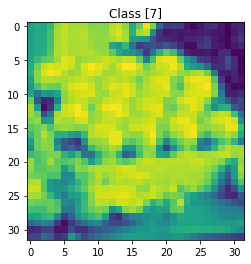

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


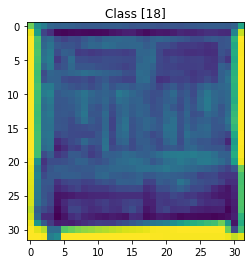

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


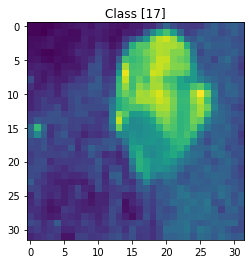

In [ ]:
for element in ds_train.take(3):
  image, label = element[0], element[1] # now its coarse
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
57/57 - 9s - loss: 2.6462 - accuracy: 0.3456 - val_loss: 1.6090 - val_accuracy: 0.5200 - 9s/epoch - 151ms/step
Epoch 2/50
57/57 - 2s - loss: 1.3219 - accuracy: 0.6333 - val_loss: 1.2026 - val_accuracy: 0.5900 - 2s/epoch - 32ms/step
Epoch 3/50
57/57 - 2s - loss: 1.0107 - accuracy: 0.7161 - val_loss: 1.0619 - val_accuracy: 0.6300 - 2s/epoch - 32ms/step
Epoch 4/50
57/57 - 2s - loss: 0.8510 - accuracy: 0.7578 - val_loss: 0.9881 - val_accuracy: 0.6300 - 2s/epoch - 32ms/step
Epoch 5/50
57/57 - 2s - loss: 0.7421 - accuracy: 0.8006 - val_loss: 0.9409 - val_accuracy: 0.6500 - 2s/epoch - 32ms/step
Epoch 6/50
57/57 - 2s - loss: 0.6608 - accuracy: 0.8256 - val_loss: 0.9096 - val_accuracy: 0.6800 - 2s/epoch - 32ms/step
Epoch 7/50
57/57 - 2s - loss: 0.5957 - accuracy: 0.8478 - val_loss: 0.8858 - val_accuracy: 0.6700 - 2s/epoch - 32ms/step
Epoch 8/50
57/57 - 2s - loss: 0.5420 - accuracy: 0.8672 - val_loss: 0.8691 - val_accuracy: 0.6700 - 2s/epoch - 32ms/step
Epoch 9/50
57/57 - 2s - loss: 0

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
57/57 - 30s - loss: 1.8913 - accuracy: 0.6278 - val_loss: 0.9846 - val_accuracy: 0.6600 - 30s/epoch - 535ms/step
Epoch 2/50
57/57 - 7s - loss: 0.4528 - accuracy: 0.9022 - val_loss: 0.8782 - val_accuracy: 0.6800 - 7s/epoch - 123ms/step
Epoch 3/50
57/57 - 7s - loss: 0.1517 - accuracy: 0.9850 - val_loss: 0.8351 - val_accuracy: 0.6850 - 7s/epoch - 122ms/step
Epoch 4/50
57/57 - 7s - loss: 0.0627 - accuracy: 0.9989 - val_loss: 0.8214 - val_accuracy: 0.7050 - 7s/epoch - 123ms/step
Epoch 5/50
57/57 - 7s - loss: 0.0339 - accuracy: 0.9994 - val_loss: 0.8127 - val_accuracy: 0.7250 - 7s/epoch - 123ms/step
Epoch 6/50
57/57 - 7s - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.8127 - val_accuracy: 0.7200 - 7s/epoch - 126ms/step
Epoch 7/50
57/57 - 7s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.8139 - val_accuracy: 0.7350 - 7s/epoch - 123ms/step
Epoch 8/50
57/57 - 7s - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.8166 - val_accuracy: 0.7250 - 7s/epoch - 122ms/step
Epoch 9/50
57/57 - 7s 

In [ ]:
history = model.evaluate(ds_test)

63/63 [==============================] - 2s 31ms/step - loss: 0.7698 - accuracy: 0.7670


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
print(predicted_categories, true_categories)

tf.Tensor([18  4 15 ... 14  2 12], shape=(2000,), dtype=int64) tf.Tensor(
[[18]
 [ 4]
 [15]
 ...
 [14]
 [ 2]
 [12]], shape=(2000, 1), dtype=int64)


Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

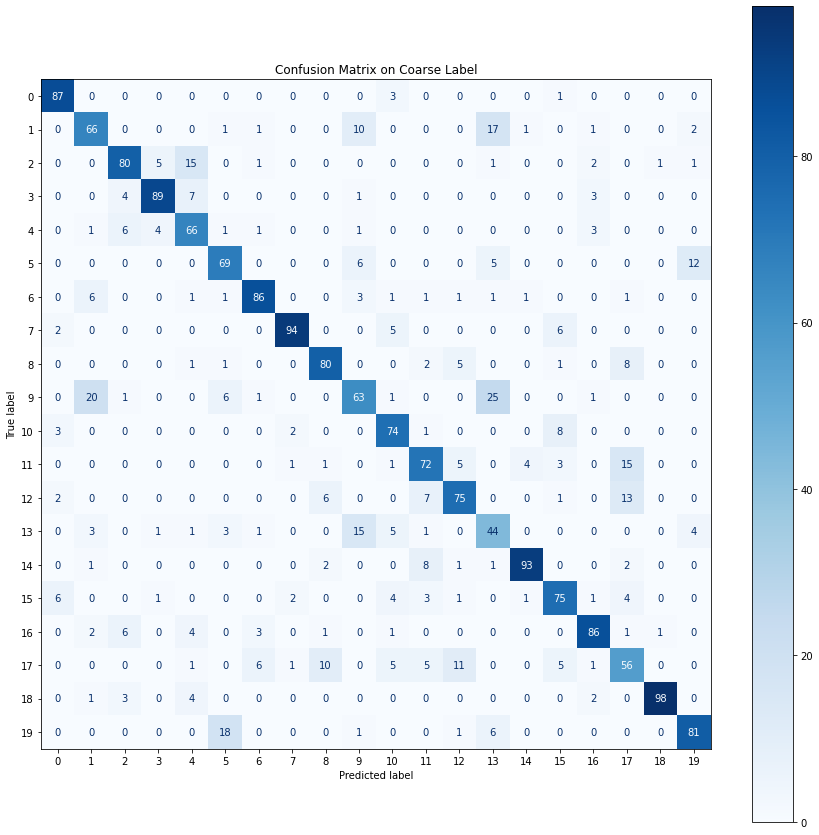

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

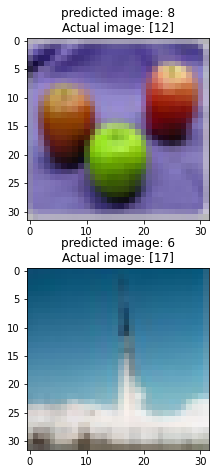

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,50))
for i in range(15):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(12,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[87  0  0  0  0  0  0  2  0  0  3  0  2  0  0  6  0  0  0  0]
 [ 0 66  0  0  1  0  6  0  0 20  0  0  0  3  1  0  2  0  1  0]
 [ 0  0 80  4  6  0  0  0  0  1  0  0  0  0  0  0  6  0  3  0]
 [ 0  0  5 89  4  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  0 15  7 66  0  1  0  1  0  0  0  0  1  0  0  4  1  4  0]
 [ 0  1  0  0  1 69  1  0  1  6  0  0  0  3  0  0  0  0  0 18]
 [ 0  1  1  0  1  0 86  0  0  1  0  0  0  1  0  0  3  6  0  0]
 [ 0  0  0  0  0  0  0 94  0  0  2  1  0  0  0  2  0  1  0  0]
 [ 0  0  0  0  0  0  0  0 80  0  0  1  6  0  2  0  1 10  0  0]
 [ 0 10  0  1  1  6  3  0  0 63  0  0  0 15  0  0  0  0  0  1]
 [ 3  0  0  0  0  0  1  5  0  1 74  1  0  5  0  4  1  5  0  0]
 [ 0  0  0  0  0  0  1  0  2  0  1 72  7  1  8  3  0  5  0  0]
 [ 0  0  0  0  0  0  1  0  5  0  0  5 75  0  1  1  0 11  0  1]
 [ 0 17  1  0  0  5  1  0  0 25  0  0  0 44  1  0  0  0  0  6]
 [ 0  1  0  0  0  0  1  0  0  0  0  4  0  0 93  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  6  1  0  8  3  1  0  0 75  0  5

## Question 3: Performance on 5-class subset of CIFAR-100
### Part 3A: Performance on "different" classes
Repeat your analysis from Part 2A, but for 5 classes chosen from 5 different superclasses.

Are your results different from Part 2A?

In [ ]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
(_, y_coarse_train), (_, y_coarse_test) =cifar100.load_data(label_mode='coarse')

size = 100
 
y_train_full_dup = y_train_full
y_test_dup=y_test

# Remove single-dimensional entries for labels
y_train_full_sq = np.squeeze(y_train_full)
y_test_sq = np.squeeze(y_test)
y_coarse_train_sq = np.squeeze(y_coarse_train)
y_coarse_test_sq = np.squeeze(y_coarse_test)

# Define empty matrices 
X_train_new=np.empty((0,32,32,3))
y_train_new=np.empty((0,1))
X_test_new=np.empty((0,32,32,3))
y_test_new=np.empty((0,1))
cls_matrix=np.empty((0,5))

# Preparing a class matrix which has all the superclass ordered
for i in np.arange(0,20,1): 
  cls_matrix=np.vstack((cls_matrix,np.unique(y_train_full[y_coarse_train_sq==i])))

In [ ]:
five_class =  np.unique(cls_matrix[[0,2,5,6,7],2])
print('Five Classes are:\n',five_class)

sum=0
for i in five_class:
  delta = np.squeeze(y_train_full==i,axis=1)
  y_train_full[delta]=sum
  X_train_new=np.vstack((X_train_new, X_train_full[delta][0:size]))
  y_train_new=np.vstack((y_train_new, y_train_full[delta][0:size]))
  sum=sum+1

sum=0
for i in five_class:
  delta=np.squeeze(y_test==i,axis=1)
  y_test[delta]=sum
  X_test_new = np.vstack((X_test_new, X_test[delta]))
  y_test_new = np.vstack((y_test_new, y_test[delta]))  
  sum=sum+1


# Randomize data for training and testing
data_points_tr = np.shape(X_train_new)[0]
data_random_tr=np.random.permutation(data_points_tr)
X_train_new=X_train_new[data_random_tr].astype(int)
y_train_new=y_train_new[data_random_tr].astype(int)

data_points_test = np.shape(X_test_new)[0]
data_random_test=np.random.permutation(data_points_test)
X_test_new=X_test_new[data_random_test].astype(int)
y_test_new=y_test_new[data_random_test].astype(int)


test_size=np.floor(len(five_class)*0.1*size).astype(int) # 10% validation size

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_new,
                                                                y_train_new,
                                                                test_size=test_size)

# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new))

Five Classes are:
 [14. 25. 40. 55. 70.]


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


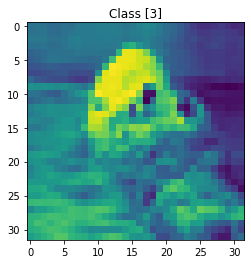

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


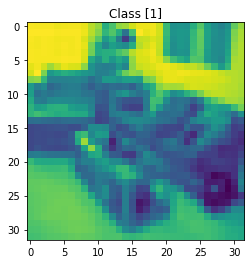

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


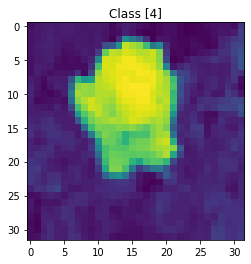

In [ ]:
import matplotlib.pyplot as plt
for element in ds_train.take(3):
  image, label = element[0], element[1] # now its coarse
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
15/15 - 9s - loss: 3.6184 - accuracy: 0.2333 - val_loss: 2.1375 - val_accuracy: 0.5400 - 9s/epoch - 582ms/step
Epoch 2/50
15/15 - 1s - loss: 1.6870 - accuracy: 0.6244 - val_loss: 1.0265 - val_accuracy: 0.7600 - 509ms/epoch - 34ms/step
Epoch 3/50
15/15 - 1s - loss: 0.9306 - accuracy: 0.8200 - val_loss: 0.6627 - val_accuracy: 0.8400 - 509ms/epoch - 34ms/step
Epoch 4/50
15/15 - 1s - loss: 0.6445 - accuracy: 0.8689 - val_loss: 0.5138 - val_accuracy: 0.8400 - 507ms/epoch - 34ms/step
Epoch 5/50
15/15 - 1s - loss: 0.5106 - accuracy: 0.8956 - val_loss: 0.4373 - val_accuracy: 0.8400 - 505ms/epoch - 34ms/step
Epoch 6/50
15/15 - 1s - loss: 0.4302 - accuracy: 0.9089 - val_loss: 0.3917 - val_accuracy: 0.8600 - 509ms/epoch - 34ms/step
Epoch 7/50
15/15 - 1s - loss: 0.3759 - accuracy: 0.9244 - val_loss: 0.3613 - val_accuracy: 0.8600 - 509ms/epoch - 34ms/step
Epoch 8/50
15/15 - 1s - loss: 0.3325 - accuracy: 0.9356 - val_loss: 0.3393 - val_accuracy: 0.8600 - 505ms/epoch - 34ms/step
Epoch 9/50

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
15/15 - 23s - loss: 3.1789 - accuracy: 0.6044 - val_loss: 0.5134 - val_accuracy: 0.9000 - 23s/epoch - 2s/step
Epoch 2/50
15/15 - 2s - loss: 0.9794 - accuracy: 0.9489 - val_loss: 0.8132 - val_accuracy: 0.9000 - 2s/epoch - 121ms/step
Epoch 3/50
15/15 - 2s - loss: 0.2755 - accuracy: 0.9889 - val_loss: 0.5996 - val_accuracy: 0.9000 - 2s/epoch - 121ms/step
Epoch 4/50
15/15 - 2s - loss: 0.1011 - accuracy: 0.9956 - val_loss: 0.5377 - val_accuracy: 0.8800 - 2s/epoch - 121ms/step
Epoch 5/50
15/15 - 2s - loss: 0.0480 - accuracy: 1.0000 - val_loss: 0.5463 - val_accuracy: 0.9200 - 2s/epoch - 121ms/step
Epoch 6/50
15/15 - 2s - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.5516 - val_accuracy: 0.9200 - 2s/epoch - 121ms/step
CPU times: user 35.8 s, sys: 1.39 s, total: 37.2 s
Wall time: 32.3 s


In [ ]:
history = model.evaluate(ds_test)

16/16 [==============================] - 1s 39ms/step - loss: 0.4323 - accuracy: 0.9060


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
#print(predicted_categories, true_categories)

Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

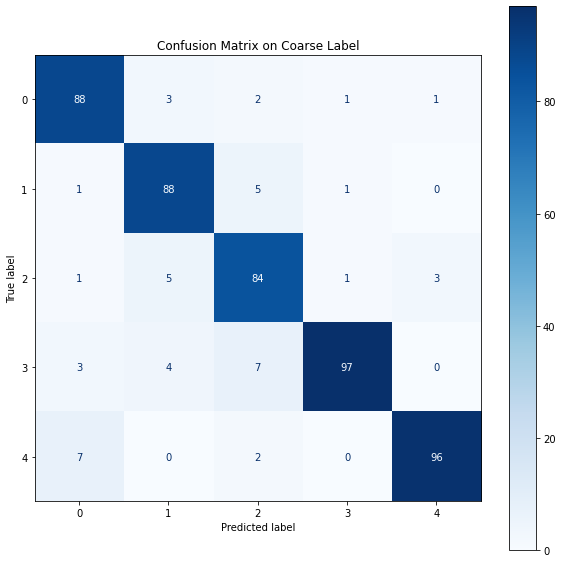

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

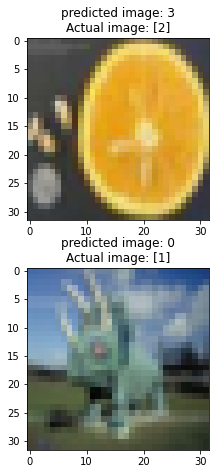

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,50))
for i in range(30):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(12,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[88  1  1  3  7]
 [ 3 88  5  4  0]
 [ 2  5 84  7  2]
 [ 1  1  1 97  0]
 [ 1  0  3  0 96]]
              precision    recall  f1-score   support

           0      0.926     0.880     0.903       100
           1      0.926     0.880     0.903       100
           2      0.894     0.840     0.866       100
           3      0.874     0.970     0.919       100
           4      0.914     0.960     0.937       100

    accuracy                          0.906       500
   macro avg      0.907     0.906     0.905       500
weighted avg      0.907     0.906     0.905       500



### Part 3B: Performance on "similar" classes
Repeat your analysis from Part 3A, but for 5 classes chosen from the SAME superclass.

Are your results different from 3A and from 2B?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
(_, y_coarse_train), (_, y_coarse_test) =cifar100.load_data(label_mode='coarse')

size = 100
 
y_train_full_dup = y_train_full
y_test_dup=y_test

# Remove single-dimensional entries for labels
y_train_full_sq = np.squeeze(y_train_full)
y_test_sq = np.squeeze(y_test)
y_coarse_train_sq = np.squeeze(y_coarse_train)
y_coarse_test_sq = np.squeeze(y_coarse_test)

# Define empty matrices 
X_train_new=np.empty((0,32,32,3))
y_train_new=np.empty((0,1))
X_test_new=np.empty((0,32,32,3))
y_test_new=np.empty((0,1))
cls_matrix=np.empty((0,5))

# Preparing a class matrix which has all the superclass ordered
for i in np.arange(0,20,1): 
  cls_matrix=np.vstack((cls_matrix,np.unique(y_train_full[y_coarse_train_sq==i])))

In [ ]:
five_class_same = np.unique(cls_matrix[12,:])
print('Five Classes are:\n',five_class_same)


sum=0
for i in five_class_same:
  delta = np.squeeze(y_train_full==i,axis=1)
  y_train_full[delta]=sum
  X_train_new=np.vstack((X_train_new, X_train_full[delta][0:size]))
  y_train_new=np.vstack((y_train_new, y_train_full[delta][0:size]))
  sum=sum+1

sum=0
for i in five_class_same:
  delta=np.squeeze(y_test==i,axis=1)
  y_test[delta]=sum
  X_test_new = np.vstack((X_test_new, X_test[delta]))
  y_test_new = np.vstack((y_test_new, y_test[delta]))  
  sum=sum+1


# Randomize data for training and testing
data_points_tr = np.shape(X_train_new)[0]
data_random_tr=np.random.permutation(data_points_tr)
X_train_new=X_train_new[data_random_tr].astype(int)
y_train_new=y_train_new[data_random_tr].astype(int)

data_points_test = np.shape(X_test_new)[0]
data_random_test=np.random.permutation(data_points_test)
X_test_new=X_test_new[data_random_test].astype(int)
y_test_new=y_test_new[data_random_test].astype(int)


test_size=np.floor(len(five_class_same)*0.1*size).astype(int) # 10% validation size

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_new,
                                                                y_train_new,
                                                                test_size=test_size)

# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new))

Five Classes are:
 [34. 63. 64. 66. 75.]


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


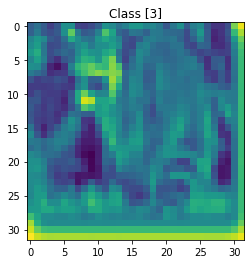

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


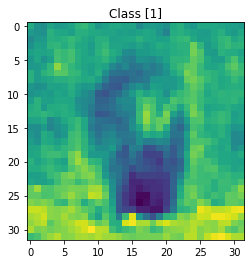

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


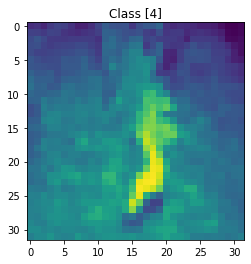

In [ ]:
import matplotlib.pyplot as plt
for element in ds_train.take(3):
  image, label = element[0], element[1] # now its coarse
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
15/15 - 7s - loss: 3.5173 - accuracy: 0.2289 - val_loss: 2.2793 - val_accuracy: 0.4600 - 7s/epoch - 463ms/step
Epoch 2/50
15/15 - 1s - loss: 1.7027 - accuracy: 0.5178 - val_loss: 1.2834 - val_accuracy: 0.6600 - 507ms/epoch - 34ms/step
Epoch 3/50
15/15 - 1s - loss: 1.1154 - accuracy: 0.7156 - val_loss: 0.9317 - val_accuracy: 0.7800 - 508ms/epoch - 34ms/step
Epoch 4/50
15/15 - 1s - loss: 0.8833 - accuracy: 0.7733 - val_loss: 0.7701 - val_accuracy: 0.7800 - 503ms/epoch - 34ms/step
Epoch 5/50
15/15 - 1s - loss: 0.7626 - accuracy: 0.7867 - val_loss: 0.6783 - val_accuracy: 0.8200 - 514ms/epoch - 34ms/step
Epoch 6/50
15/15 - 1s - loss: 0.6830 - accuracy: 0.8111 - val_loss: 0.6195 - val_accuracy: 0.8400 - 515ms/epoch - 34ms/step
Epoch 7/50
15/15 - 1s - loss: 0.6228 - accuracy: 0.8311 - val_loss: 0.5791 - val_accuracy: 0.8400 - 512ms/epoch - 34ms/step
Epoch 8/50
15/15 - 1s - loss: 0.5762 - accuracy: 0.8400 - val_loss: 0.5493 - val_accuracy: 0.8400 - 508ms/epoch - 34ms/step
Epoch 9/50

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
15/15 - 24s - loss: 3.4186 - accuracy: 0.4889 - val_loss: 0.8459 - val_accuracy: 0.8200 - 24s/epoch - 2s/step
Epoch 2/50
15/15 - 2s - loss: 1.2769 - accuracy: 0.8844 - val_loss: 1.1032 - val_accuracy: 0.8000 - 2s/epoch - 121ms/step
Epoch 3/50
15/15 - 2s - loss: 0.4109 - accuracy: 0.9733 - val_loss: 0.9299 - val_accuracy: 0.8200 - 2s/epoch - 120ms/step
Epoch 4/50
15/15 - 2s - loss: 0.1329 - accuracy: 1.0000 - val_loss: 0.8731 - val_accuracy: 0.8000 - 2s/epoch - 120ms/step
Epoch 5/50
15/15 - 2s - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.7731 - val_accuracy: 0.8200 - 2s/epoch - 120ms/step
Epoch 6/50
15/15 - 2s - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.7400 - val_accuracy: 0.8200 - 2s/epoch - 121ms/step
Epoch 7/50
15/15 - 2s - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.7268 - val_accuracy: 0.8400 - 2s/epoch - 121ms/step
Epoch 8/50
15/15 - 2s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.7154 - val_accuracy: 0.8400 - 2s/epoch - 121ms/step
Epoch 9/50
15/15 - 2s - l

In [ ]:
history = model.evaluate(ds_test)

16/16 [==============================] - 1s 30ms/step - loss: 0.6485 - accuracy: 0.8380


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
#print(predicted_categories, true_categories)

Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

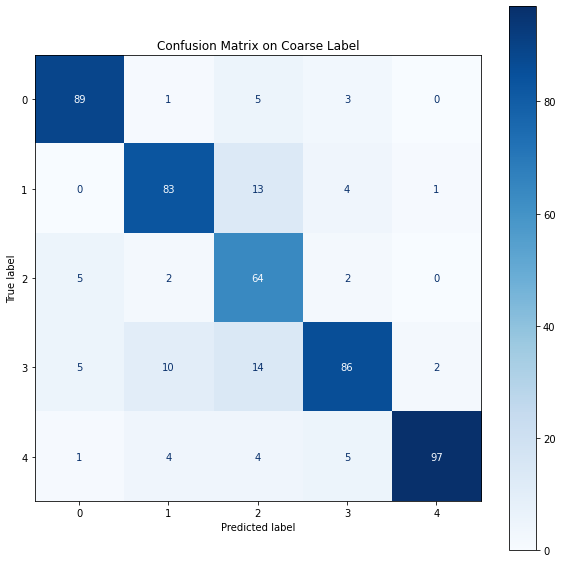

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

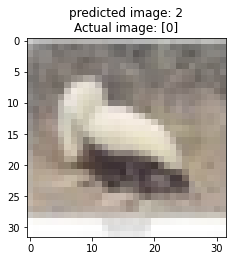

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,30))
for i in range(14):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(7,2,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[89  0  5  5  1]
 [ 1 83  2 10  4]
 [ 5 13 64 14  4]
 [ 3  4  2 86  5]
 [ 0  1  0  2 97]]
              precision    recall  f1-score   support

           0      0.908     0.890     0.899       100
           1      0.822     0.830     0.826       100
           2      0.877     0.640     0.740       100
           3      0.735     0.860     0.793       100
           4      0.874     0.970     0.919       100

    accuracy                          0.838       500
   macro avg      0.843     0.838     0.835       500
weighted avg      0.843     0.838     0.835       500



## Question 4: Performance on 2-class subset of CIFAR-100
### Part 4A: Performance on "different" classes
Create a binary classifier, choosing two classes from different superclasses.
Repeat analysis from Part 3A.

Are your results different than previous Parts?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
(_, y_coarse_train), (_, y_coarse_test) =cifar100.load_data(label_mode='coarse')

size = 100
 
y_train_full_dup = y_train_full
y_test_dup=y_test

# Remove single-dimensional entries for labels
y_train_full_sq = np.squeeze(y_train_full)
y_test_sq = np.squeeze(y_test)
y_coarse_train_sq = np.squeeze(y_coarse_train)
y_coarse_test_sq = np.squeeze(y_coarse_test)

# Define empty matrices 
X_train_new=np.empty((0,32,32,3))
y_train_new=np.empty((0,1))
X_test_new=np.empty((0,32,32,3))
y_test_new=np.empty((0,1))
cls_matrix=np.empty((0,5))

# Preparing a class matrix which has all the superclass ordered
for i in np.arange(0,20,1): 
  cls_matrix=np.vstack((cls_matrix,np.unique(y_train_full[y_coarse_train_sq==i])))

In [ ]:
two_class = np.unique(cls_matrix[[12,15],3])
print('Two Classes are:\n',two_class)


sum=0
for i in two_class:
  delta = np.squeeze(y_train_full==i,axis=1)
  y_train_full[delta]=sum
  X_train_new=np.vstack((X_train_new, X_train_full[delta][0:size]))
  y_train_new=np.vstack((y_train_new, y_train_full[delta][0:size]))
  sum=sum+1

sum=0
for i in two_class:
  delta=np.squeeze(y_test==i,axis=1)
  y_test[delta]=sum
  X_test_new = np.vstack((X_test_new, X_test[delta]))
  y_test_new = np.vstack((y_test_new, y_test[delta]))  
  sum=sum+1


# Randomize data for training and testing
data_points_tr = np.shape(X_train_new)[0]
data_random_tr=np.random.permutation(data_points_tr)
X_train_new=X_train_new[data_random_tr].astype(int)
y_train_new=y_train_new[data_random_tr].astype(int)

data_points_test = np.shape(X_test_new)[0]
data_random_test=np.random.permutation(data_points_test)
X_test_new=X_test_new[data_random_test].astype(int)
y_test_new=y_test_new[data_random_test].astype(int)


test_size=np.floor(len(two_class)*0.1*size).astype(int) # 10% validation size

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_new,
                                                                y_train_new,
                                                                test_size=test_size)

# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new))

Two Classes are:
 [66. 78.]


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


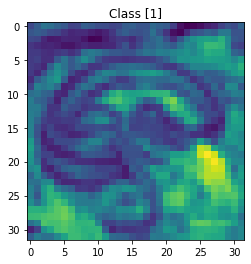

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


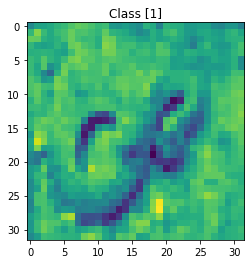

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


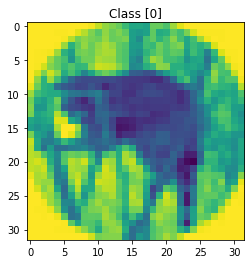

In [ ]:
import matplotlib.pyplot as plt
for element in ds_train.take(3):
  image, label = element[0], element[1]
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
6/6 - 8s - loss: 4.1521 - accuracy: 0.2222 - val_loss: 3.5043 - val_accuracy: 0.3500 - 8s/epoch - 1s/step
Epoch 2/50
6/6 - 0s - loss: 2.8198 - accuracy: 0.5000 - val_loss: 2.2699 - val_accuracy: 0.4000 - 246ms/epoch - 41ms/step
Epoch 3/50
6/6 - 0s - loss: 1.7010 - accuracy: 0.6389 - val_loss: 1.3693 - val_accuracy: 0.6000 - 249ms/epoch - 41ms/step
Epoch 4/50
6/6 - 0s - loss: 0.9940 - accuracy: 0.8000 - val_loss: 0.8497 - val_accuracy: 0.8000 - 249ms/epoch - 42ms/step
Epoch 5/50
6/6 - 0s - loss: 0.6220 - accuracy: 0.9167 - val_loss: 0.5816 - val_accuracy: 0.9000 - 241ms/epoch - 40ms/step
Epoch 6/50
6/6 - 0s - loss: 0.4366 - accuracy: 0.9333 - val_loss: 0.4417 - val_accuracy: 0.9500 - 244ms/epoch - 41ms/step
Epoch 7/50
6/6 - 0s - loss: 0.3391 - accuracy: 0.9556 - val_loss: 0.3629 - val_accuracy: 0.9500 - 248ms/epoch - 41ms/step
Epoch 8/50
6/6 - 0s - loss: 0.2798 - accuracy: 0.9500 - val_loss: 0.3148 - val_accuracy: 0.9500 - 242ms/epoch - 40ms/step
Epoch 9/50
6/6 - 0s - loss: 0

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
6/6 - 23s - loss: 3.7465 - accuracy: 0.5278 - val_loss: 0.1810 - val_accuracy: 0.9500 - 23s/epoch - 4s/step
Epoch 2/50
6/6 - 1s - loss: 2.3392 - accuracy: 0.8278 - val_loss: 0.2839 - val_accuracy: 0.9500 - 758ms/epoch - 126ms/step
Epoch 3/50
6/6 - 1s - loss: 1.2663 - accuracy: 0.9556 - val_loss: 0.4501 - val_accuracy: 0.9500 - 759ms/epoch - 127ms/step
Epoch 4/50
6/6 - 1s - loss: 0.5940 - accuracy: 0.9833 - val_loss: 0.6085 - val_accuracy: 0.9500 - 755ms/epoch - 126ms/step
Epoch 5/50
6/6 - 1s - loss: 0.2627 - accuracy: 1.0000 - val_loss: 0.7667 - val_accuracy: 1.0000 - 756ms/epoch - 126ms/step
Epoch 6/50
6/6 - 1s - loss: 0.1222 - accuracy: 1.0000 - val_loss: 0.8175 - val_accuracy: 0.9000 - 753ms/epoch - 125ms/step
CPU times: user 28.2 s, sys: 749 ms, total: 29 s
Wall time: 26.9 s


In [ ]:
history = model.evaluate(ds_test)

7/7 [==============================] - 0s 27ms/step - loss: 0.7138 - accuracy: 0.9650


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
#print(predicted_categories, true_categories)

Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

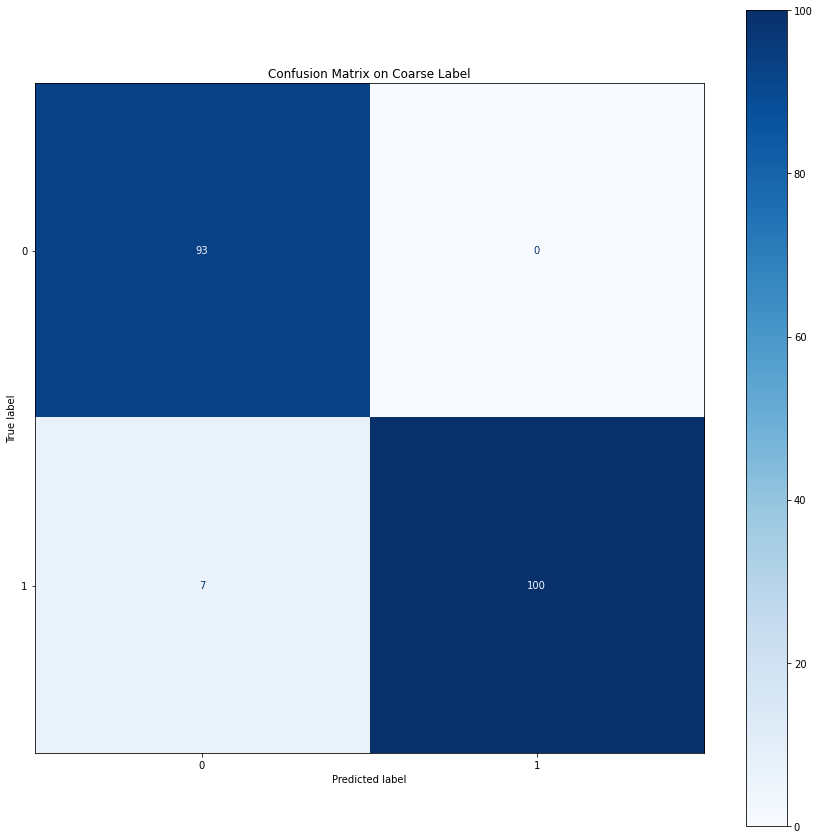

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

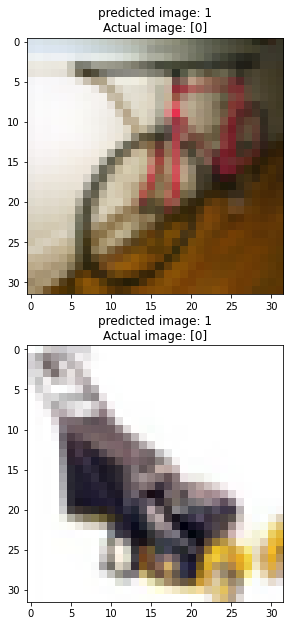

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (40,50))
for i in range(33):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(9,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[ 93   7]
 [  0 100]]
              precision    recall  f1-score   support

           0      1.000     0.930     0.964       100
           1      0.935     1.000     0.966       100

    accuracy                          0.965       200
   macro avg      0.967     0.965     0.965       200
weighted avg      0.967     0.965     0.965       200



### Part 4B: Performance on "similar" classes
Choose your two classes from the same superclass, and repeat analysis.

What are your results?

In [ ]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import itertools
import tensorflow_datasets as tfds
from sklearn.datasets import make_multilabel_classification

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
(_, y_coarse_train), (_, y_coarse_test) =cifar100.load_data(label_mode='coarse')

size = 100
 
y_train_full_dup = y_train_full
y_test_dup=y_test

# Remove single-dimensional entries for labels
y_train_full_sq = np.squeeze(y_train_full)
y_test_sq = np.squeeze(y_test)
y_coarse_train_sq = np.squeeze(y_coarse_train)
y_coarse_test_sq = np.squeeze(y_coarse_test)

# Define empty matrices 
X_train_new=np.empty((0,32,32,3))
y_train_new=np.empty((0,1))
X_test_new=np.empty((0,32,32,3))
y_test_new=np.empty((0,1))
cls_matrix=np.empty((0,5))

# Preparing a class matrix which has all the superclass ordered
for i in np.arange(0,20,1): 
  cls_matrix=np.vstack((cls_matrix,np.unique(y_train_full[y_coarse_train_sq==i])))

In [ ]:
two_class_same = np.unique(cls_matrix[10,[1,3]])
print('Two Classes are:\n',two_class_same)


sum=0
for i in two_class_same:
  delta = np.squeeze(y_train_full==i,axis=1)
  y_train_full[delta]=sum
  X_train_new=np.vstack((X_train_new, X_train_full[delta][0:size]))
  y_train_new=np.vstack((y_train_new, y_train_full[delta][0:size]))
  sum=sum+1

sum=0
for i in two_class_same:
  delta=np.squeeze(y_test==i,axis=1)
  y_test[delta]=sum
  X_test_new = np.vstack((X_test_new, X_test[delta]))
  y_test_new = np.vstack((y_test_new, y_test[delta]))  
  sum=sum+1


# Randomize data for training and testing
data_points_tr = np.shape(X_train_new)[0]
data_random_tr=np.random.permutation(data_points_tr)
X_train_new=X_train_new[data_random_tr].astype(int)
y_train_new=y_train_new[data_random_tr].astype(int)

data_points_test = np.shape(X_test_new)[0]
data_random_test=np.random.permutation(data_points_test)
X_test_new=X_test_new[data_random_test].astype(int)
y_test_new=y_test_new[data_random_test].astype(int)


test_size=np.floor(len(two_class_same)*0.1*size).astype(int) # 10% validation size

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_new,
                                                                y_train_new,
                                                                test_size=test_size)

# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_new, y_test_new))

Two Classes are:
 [33. 60.]


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


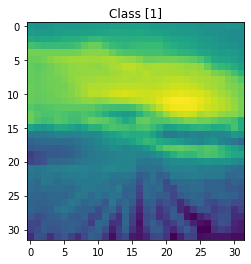

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


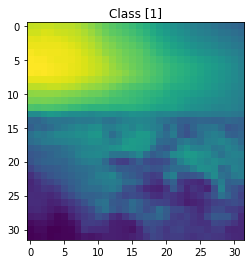

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


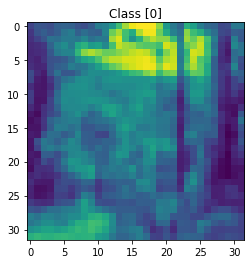

In [ ]:
for element in ds_train.take(3):
  image, label = element[0], element[1] # now its coarse
  image.shape
#  type(image.numpy()[:,:,0])
#  type(image)
  plt.imshow(image.numpy()[:,:,0])
  type(image.numpy())
  type(label)
  print(ds_train)
  #coarse_id_fine_id[id] = fine_labels_ids
  plt.title("Class" + " " +str(label.numpy()))
  plt.show()

In [ ]:
# Build pipeline
batch = 32

def preprocess(image, label):
  image = tf.image.resize(image,[224,224])
  #label = tf.label_mode(int("coarse"))
  return (image, label)


def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  return (image, label)
#image.shape 

ds_train=ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid=ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test=ds_test.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.005)(global_avg) 
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train, 
                    epochs=50, validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
6/6 - 7s - loss: 3.9601 - accuracy: 0.2611 - val_loss: 3.1952 - val_accuracy: 0.3500 - 7s/epoch - 1s/step
Epoch 2/50
6/6 - 0s - loss: 2.5905 - accuracy: 0.6278 - val_loss: 1.9312 - val_accuracy: 0.5500 - 245ms/epoch - 41ms/step
Epoch 3/50
6/6 - 0s - loss: 1.4933 - accuracy: 0.7389 - val_loss: 1.1024 - val_accuracy: 0.8500 - 246ms/epoch - 41ms/step
Epoch 4/50
6/6 - 0s - loss: 0.8797 - accuracy: 0.8556 - val_loss: 0.6866 - val_accuracy: 0.9000 - 245ms/epoch - 41ms/step
Epoch 5/50
6/6 - 0s - loss: 0.5908 - accuracy: 0.9167 - val_loss: 0.4830 - val_accuracy: 0.9000 - 248ms/epoch - 41ms/step
Epoch 6/50
6/6 - 0s - loss: 0.4481 - accuracy: 0.9278 - val_loss: 0.3740 - val_accuracy: 0.9500 - 246ms/epoch - 41ms/step
Epoch 7/50
6/6 - 0s - loss: 0.3668 - accuracy: 0.9389 - val_loss: 0.3100 - val_accuracy: 0.9500 - 250ms/epoch - 42ms/step
Epoch 8/50
6/6 - 0s - loss: 0.3136 - accuracy: 0.9444 - val_loss: 0.2684 - val_accuracy: 0.9500 - 250ms/epoch - 42ms/step
Epoch 9/50
6/6 - 0s - loss: 0

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

#n_epochs = 1
history = model.fit(ds_train,
                    epochs=50,
                    validation_data=ds_valid, verbose = 2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
6/6 - 24s - loss: 5.8120 - accuracy: 0.1778 - val_loss: 0.1536 - val_accuracy: 1.0000 - 24s/epoch - 4s/step
Epoch 2/50
6/6 - 1s - loss: 3.9952 - accuracy: 0.5222 - val_loss: 0.5184 - val_accuracy: 1.0000 - 752ms/epoch - 125ms/step
Epoch 3/50
6/6 - 1s - loss: 2.2232 - accuracy: 0.9000 - val_loss: 0.6834 - val_accuracy: 1.0000 - 757ms/epoch - 126ms/step
Epoch 4/50
6/6 - 1s - loss: 0.8967 - accuracy: 0.9889 - val_loss: 0.4971 - val_accuracy: 1.0000 - 756ms/epoch - 126ms/step
Epoch 5/50
6/6 - 1s - loss: 0.3315 - accuracy: 0.9889 - val_loss: 0.3419 - val_accuracy: 1.0000 - 754ms/epoch - 126ms/step
Epoch 6/50
6/6 - 1s - loss: 0.1548 - accuracy: 0.9944 - val_loss: 0.2771 - val_accuracy: 0.9500 - 756ms/epoch - 126ms/step
CPU times: user 28.9 s, sys: 790 ms, total: 29.7 s
Wall time: 27.7 s


In [ ]:
history = model.evaluate(ds_test)

7/7 [==============================] - 0s 29ms/step - loss: 0.3974 - accuracy: 0.9100


In [ ]:
y_pred_fine = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred_fine, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)
#print(predicted_categories, true_categories)

Text(0.5, 1.0, 'Confusion Matrix on Coarse Label')

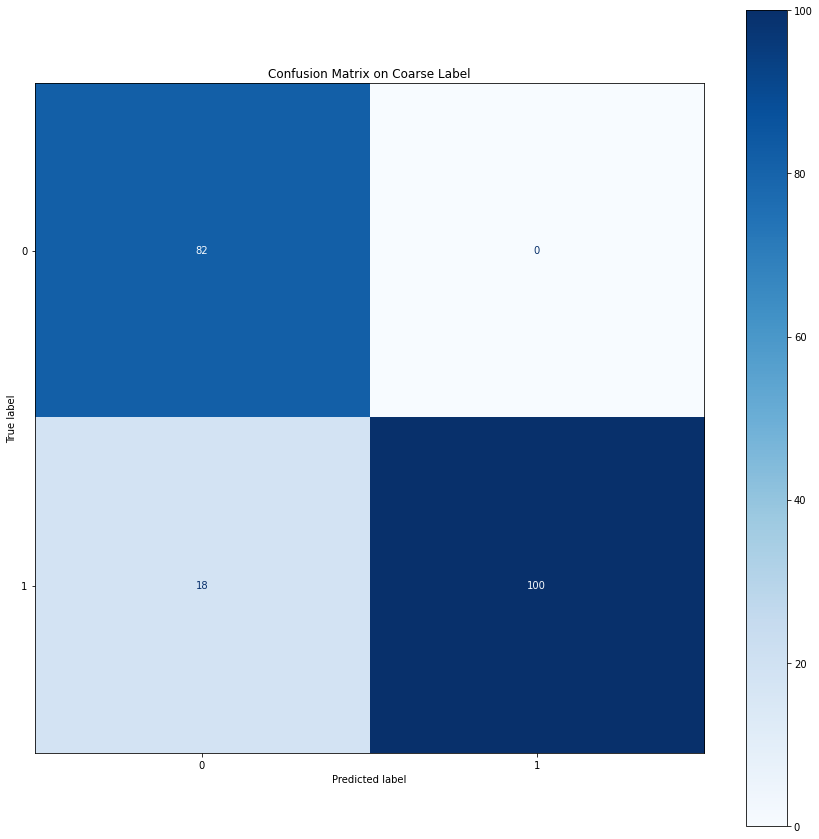

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from unicodedata import normalize
import itertools

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(25))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix on Coarse Label")

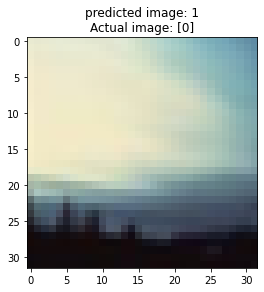

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (40,50))
for i in range(4,9):
  if predicted_categories[i] != true_categories[i]:
    plt.subplot(10,3,i+1)
    plt.imshow(X_test[i])
    plt.title(f'predicted image: {predicted_categories[i]}' '\n' f'Actual image: {true_categories[i]}')
#fig.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

from tensorflow.python.ops.numpy_ops import np_config

from itertools import chain 
TT = list(chain(*true_categories.numpy())) 

np_config.enable_numpy_behavior()
PT = predicted_categories.tolist()


labels = TT
guesses =PT

# True values
y_true = TT
# Predicted values
y_pred = PT

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[ 82  18]
 [  0 100]]
              precision    recall  f1-score   support

           0      1.000     0.820     0.901       100
           1      0.847     1.000     0.917       100

    accuracy                          0.910       200
   macro avg      0.924     0.910     0.909       200
weighted avg      0.924     0.910     0.909       200



## Question 5: Summarize your findings
Are there any mathematical relationships between number of classes, accuracy, and number of images used in training data? Did it make a difference if the classes were different or similar? Provide any other analyses or interesting insights.

In this project, I have built up the same pipeline along with the same transfer learning model for all of the cases. In each case, the data has varied in the number of classes along with datasets. For each case, I have analyzed accuracy, precision, recall, f-score, and macro-average metrics to define the changes within the cases. 
If I consider the number of classes vs model accuracy, I can see that accuracy increases with the increment of the number of classes.

For two classes (4A): accuracy: 96.5%

For five classes (3A): accuracy: 90.6%

For 19-classes- 2000 images (2A): accuracy: 88.9%

For 19-classes-10000 images (19-class, 1): accuracy: 89.6%%

For 100-classes (all-class, 1): accuracy: 81.4%

With the increment in the number of classes, the model analysis becomes more complex, which results in a decrement in the model accuracy. Even if I consider the macro averaging in precision, I can find the difference for each case.

For two classes (4A): macro-averaging: 96.7%

For five classes (3A): macro-averaging: 90.7%

For 19-classes (2A): macro-averaging: 89.1%

For 100-classes (all-class, 1): macro-averaging: 81.7%

If I focus on the number of data, we can also find the classification metrics differences between them. With the increment of the number of images. As the sample size increases, the model has to go through lots of decision procedures which results showing less accuracy of the model. For example—

For 200 images (4A): accuracy: 96.5%

For 500 images (3A): accuracy: 90.6%

For 2,000 images (2A): accuracy: 88.9%

For 10,000 images (19-class): accuracy: 89.6%

For 10,000 images (all-class): accuracy: 81.4%

The interesting fact is that, while I am analyzing those classification metrics, I have found that together with classes and the number of images the classification metrics vary a lot. For example—

For 19-classes- 2000 images (2A): accuracy: 88.9%

For 19-classes-10000 images (19-class, 1): accuracy: 89.6%

For 100-classes-10000 images (all-class, 1): accuracy: 81.4%

With increasing the number of images in the same number of classes, the model accuracy has increased by about 8%. On the other hand, by the increment of the number of classes for the same number of images, the model accuracy has decreased by about 9%. However, for better model evaluation, both the number of images and the number of classes should be increased.